In [978]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import qmc    # quasi-Monte Carlo for latin hypercube sampling
from scipy.stats import mstats 
from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram
import scipy.optimize as opt

from scipy.stats import norm, weibull_min, beta


import warnings
warnings.filterwarnings("ignore")


N = 10000                # random numbers to generate

# Drawing Random Variates

## Latin Hypercube Sampling

In [979]:
# Latin Hypercube LHS sampling of uniform random numbers

sampler = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample = sampler.random(n=10)
print(type(sampler))
sample

<class 'scipy.stats._qmc.LatinHypercube'>


array([[0.7226044 ],
       [0.05611216],
       [0.41414021],
       [0.2302632 ],
       [0.39058227],
       [0.50243776],
       [0.12388603],
       [0.82139357],
       [0.68718864],
       [0.95496141]])

In [980]:
# quality of sample
qmc.discrepancy(sample)

0.001761364104473806

In [981]:
# samples can be rescaled to fit between the defined bounds
seq = qmc.scale(sample, 0, 100)
print(type(seq))
seq

<class 'numpy.ndarray'>


array([[72.26043951],
       [ 5.6112156 ],
       [41.4140208 ],
       [23.02631971],
       [39.05822652],
       [50.24377648],
       [12.38860298],
       [82.13935695],
       [68.71886367],
       [95.49614062]])

## PERT random variates

In [982]:
# define a new class pertm_gen: a generator for the PERT distribution

class pertm_gen(rv_continuous):
    '''modified beta_PERT distribution'''

 
    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = beta.cdf(z, s_alpha, s_beta)
        return cdf

    def _ppf(self, p, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        ppf = beta.ppf(p, s_alpha, s_beta)
        ppf = ppf * (max - min) + min
        return ppf


    def _mean(self, min, mode, max, lmb):
        mean = (min + lmb * mode + max) / (2 + lmb)
        return mean

    def _var(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = (mean - min) * (max - mean) / (lmb + 3)
        return var

    def _skew(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        skew1 = (min + max - 2*mean) / 4
        skew2 = (mean - min) * (max  - mean)
        skew2 = np.sqrt(7 / skew2)
        skew = skew1 * skew2
        return skew

    def _kurt(self, min, mode, max, lmb):
        a1,a2 = self._shape(min, mode, max, lmb)
        kurt1 = a1 + a2 +1
        kurt2 = 2 * (a1 + a2)**2
        kurt3 = a1 * a2 * (a1 + a2 - 6)
        kurt4 = a1 * a2 * (a1 + a2 + 2) * (a1 + a2 + 3)
        kurt5 = 3 * kurt1 * (kurt2 + kurt3)
        kurt = kurt5 / kurt4 -  3                 # scipy defines kurtosis of std normal distribution as 0 instead of 3
        return kurt

    def _stats(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = self._var(min, mode, max, lmb)
        skew = self._skew(min, mode, max, lmb)
        kurt = self._kurt(min, mode, max, lmb)
        return mean, var, skew, kurt


In [983]:
# create a PERT instance 
# expected sales volume

min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0


# instantiate a PERT object
pertm = pertm_gen(name="pertm")
rvP = pertm(min,mode,max,lmb)
statsP = rvP.stats("mvsk")

moments = [np.asscalar(v) for v in statsP]
moment_names = ["mean", "var", "skew", "kurt"]
dict_moments = dict(zip(moment_names, moments))
_ = [print(k,":",f'{v:.2f}') for k,v in dict_moments.items()]

mean : 12333.33
var : 3507936.51
skew : 0.18
kurt : -0.62


No handles with labels found to put in legend.


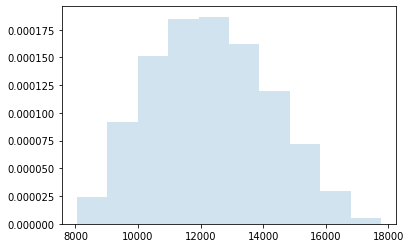

In [984]:
# PERT random variates with LHS
sampler01 = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
sample01 = sampler01.random(n=N)
randP = rvP.ppf(sample01)

fig, ax = plt.subplots(1, 1)
ax.hist(randP, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


## Normal random variates

No handles with labels found to put in legend.


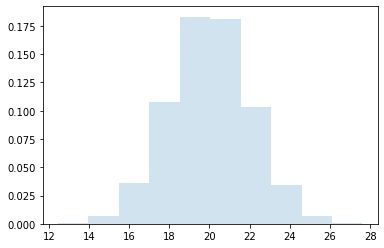

In [985]:
# normal random variates with LHS
# selling price

m1, s1 = 20.0, 2.0

sampler02 = qmc.LatinHypercube(d=1, seed=43)    # d = dimension
sample02 = sampler02.random(n=N)
rvN1 = norm(m1,s1)
randN1 = rvN1.ppf(sample02)

fig, ax = plt.subplots(1, 1)
ax.hist(randN1, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


No handles with labels found to put in legend.


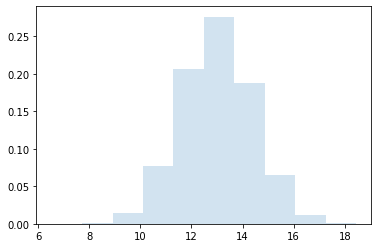

In [986]:
# Normal random variates with LHS: 
# raw material unit cost

m2, s2 = 13.0, 1.4

sampler02 = qmc.LatinHypercube(d=1, seed=44)    # d = dimension
sample02 = sampler02.random(n=N)
rvN2 = norm(m2,s2)
randN2 = rvN2.ppf(sample02)

fig, ax = plt.subplots(1, 1)
ax.hist(randN2, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


# Simulation Model 1: Sums and Products of Random Variates

In [987]:
def dist_properties(data):

    # moments
    mean = data.mean()
    s = data.std()
    min = data.min()
    max = data.max()
    skew = np.asscalar(stats.skew(data))
    kurt = np.asscalar(stats.kurtosis(data))

    moment_names = ["mean", "std", "min", "max", "skew", "kurt"]
    moments = [mean,s,min,max,skew,kurt]
    dict_moments = dict(zip(moment_names, moments))
    _ = [print(k,":",f'{v:.3f}') for k,v in dict_moments.items()]


    # quantiles
    q1 = np.array([0.001, 0.01, 0.99, 0.999])
    q2 = np.arange(0.05, 0.95, 0.05)
    q = np.concatenate((q1,q2))
    q.sort()
    xq = np.quantile(data, q)
    
    qstr = [str(f'{v:.3f}') for v in q]
    dict_quantiles = dict(zip(qstr, xq))
    print("\nquantiles:")
    _ = [print(q,":",f'{xq:,.0f}') for q,xq in dict_quantiles.items()]


    # moments & quantiles
    metric_names = moment_names.extend(q)
    metrics = moments.extend(xq)
    dict_metrics = {**dict_moments, **dict_quantiles}
    return dict_metrics


In [988]:
v = randP           # array of random variates representing the sales volume
p = randN1          # random array for selling price
m = randN2          # random array for material unit cost
o = 3.0             #other unit cost, deterministic

No handles with labels found to put in legend.


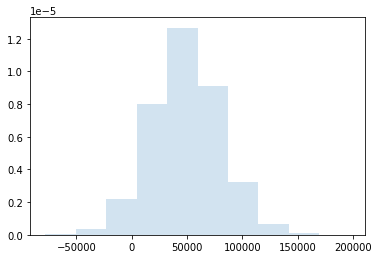

In [989]:
# The target variable of the simulation mode
# gross profit = volume * (price - material unit cost - other unit cost) 

randGP = v * (p - m - o)

fig, ax = plt.subplots(1, 1)
ax.hist(randGP, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


randR = v * p


No handles with labels found to put in legend.


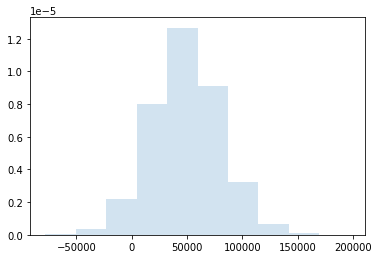

In [990]:
# secondary target variable of the simulation mode
# revenues

randR = v * p

fig, ax = plt.subplots(1, 1)
ax.hist(randGP, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass

In [991]:
# get the properties of the GP array
GP_metrics = dist_properties(randGP)

mean : 49250.197
std : 31099.637
min : -77986.549
max : 197206.000
skew : 0.121
kurt : 0.220

quantiles:
0.001 : -44,760
0.010 : -22,702
0.050 : -716
0.100 : 10,731
0.150 : 17,715
0.200 : 23,171
0.250 : 28,502
0.300 : 32,885
0.350 : 36,967
0.400 : 40,922
0.450 : 44,404
0.500 : 48,507
0.550 : 52,454
0.600 : 56,296
0.650 : 60,549
0.700 : 64,858
0.750 : 69,288
0.800 : 74,944
0.850 : 81,321
0.900 : 88,847
0.990 : 125,788
0.999 : 151,089


# Simulation 2: Nested Random Variables

In [992]:
# Weibull shape parameter:
shp_m, shp_s = 1.5, 0.1                 # Weibull shape parameter: normally distributed
scl_min, scl_mode, scl_max, scl_lmb = 45000, 50000, 60000, 8.0  # weibull scale parameter: PERT 3-point-estimate

In [993]:
# generate 10,000 normal random variates 

def wei_shp(mean,std):
    sampler = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
    sample = sampler.random(n=N)

    rv = norm(mean, std)
    rand = rv.ppf(sample)
    return rand

In [994]:
# generate 10,000 PERT random numbers

def wei_charlife(min,mode,max,lmb):
    sampler = qmc.LatinHypercube(d=1, seed=42)    # d = dimension
    sample = sampler.random(n=N)
 
    pertm = pertm_gen(name="pertm")
    rv = pertm(min, mode, max, lmb)
    rand = rv.ppf(sample)
    return rand
    

No handles with labels found to put in legend.


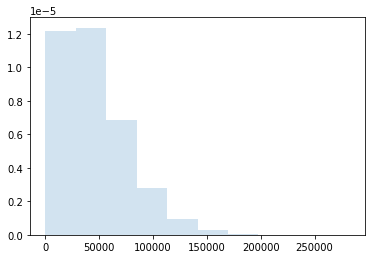

In [995]:
# Weibull_Min random variates with LHS

loc = 0.0

sampler4 = qmc.LatinHypercube(d=1, seed=48)    # d = dimension
sample4 = sampler4.random(n=N)
rand_CL = weibull_min.ppf(sample4, wei_shp(shp_m, shp_s), loc, wei_charlife(scl_min, scl_mode, scl_max, scl_lmb))


fig, ax = plt.subplots(1, 1)
ax.hist(rand_CL, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


In [996]:
# properties of the simulation results
flexWeib = dist_properties(rand_CL)

mean : 45647.116
std : 31145.403
min : 70.807
max : 282732.985
skew : 1.092
kurt : 1.615

quantiles:
0.001 : 444
0.010 : 2,273
0.050 : 6,814
0.100 : 11,076
0.150 : 14,945
0.200 : 18,389
0.250 : 21,728
0.300 : 25,255
0.350 : 28,812
0.400 : 32,169
0.450 : 35,874
0.500 : 39,832
0.550 : 43,555
0.600 : 47,822
0.650 : 52,212
0.700 : 57,461
0.750 : 62,893
0.800 : 69,516
0.850 : 77,651
0.900 : 88,094
0.990 : 139,818
0.999 : 184,118


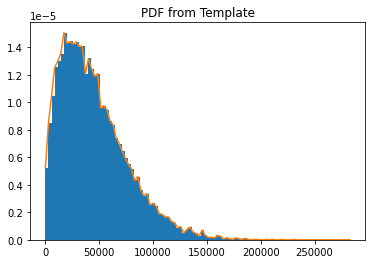

In [997]:
# create a distribution object from the simulated output variable by using rv_histogram

data = rand_CL
hist = np.histogram(data, bins=100)
histdist = rv_histogram(hist)

X = np.linspace(data.min(), data.max(), 100)
plt.title("PDF from Template")
plt.hist(data, density=True, bins=100)
plt.plot(X, histdist.pdf(X), label='PDF')
plt.show()


In [998]:
# histogram-based probability distribution

def histdist_properties(histdist):
    
    # moments
    mean = histdist.mean()
    s = histdist.std()
    median = histdist.median()
    min = histdist.support()[0]
    max = histdist.support()[1]
    stats =histdist.stats()

    metric_names = ["mean", "std", "median", "min", "max"]
    metrics = [mean, s, median, min, max]
    dict_metrics = dict(zip(metric_names, metrics))
    print("histogram-based probability distribution:")
    _ = [print(k,":",f'{v:.3f}') for k,v in dict_metrics.items()]


    # choose some probabilities of interest
    q1 = np.array([0.001, 0.01, 0.99, 0.999])
    q2 = np.arange(0.05, 0.95, 0.05)
    q = np.concatenate((q1,q2))
    q.sort()
    q

    # we can generate some random variables
    randH = histdist.rvs(size=len(q))

    # calculate quantiles, cdf and pdf at selected points
    ppf_res = histdist.ppf(q)
    pdf_res = histdist.pdf(ppf_res)
    cdf_res = histdist.cdf(ppf_res)
    pd.options.display.float_format = '{:,.3f}'.format
    dfH = pd.DataFrame()
    dfH["metrics"] = q
    dfH["quantiles"] = ppf_res
    dfH["cdf"] = cdf_res
    dfH["rand.variates"] = randH
    
    return dfH


In [999]:
histdist_properties(histdist)

histogram-based probability distribution:
mean : 45656.585
std : 31159.544
median : 39832.964
min : 70.807
max : 282732.985


,metrics,quantiles,cdf,rand.variates
0,0.001,261.795,0.001,"6,196.965"
1,0.010,"1,980.687",0.010,"23,981.120"
2,0.050,"6,784.034",0.050,"90,447.488"
3,0.100,"11,058.802",0.100,"5,516.570"
4,0.150,"14,890.276",0.150,"32,061.382"
5,0.200,"18,423.943",0.200,"22,708.112"
6,0.250,"21,844.191",0.250,"52,426.717"
7,0.300,"25,316.419",0.300,"23,198.160"
8,0.350,"28,816.231",0.350,"46,429.685"
9,0.400,"32,314.181",0.400,"24,612.830"


No handles with labels found to put in legend.


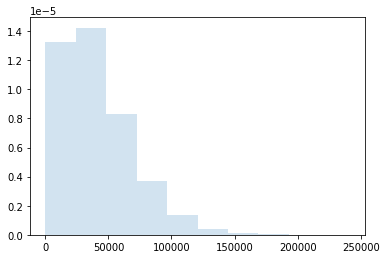

In [1000]:
# Weibull_Min with fixed parameters

loc2 = loc
shp2 = shp_m
scl2 = rand_CL.mean()

rand_fix = weibull_min.ppf(sample4, shp2, loc2, scl2)


fig, ax = plt.subplots(1, 1)
ax.hist(rand_fix, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass


In [1001]:
# properties of the simulation results
fixWeib = dist_properties(rand_fix)

mean : 41209.511
std : 27992.097
min : 54.426
max : 241361.266
skew : 1.080
kurt : 1.475

quantiles:
0.001 : 467
0.010 : 2,137
0.050 : 6,302
0.100 : 10,183
0.150 : 13,597
0.200 : 16,796
0.250 : 19,896
0.300 : 22,958
0.350 : 26,038
0.400 : 29,172
0.450 : 32,395
0.500 : 35,754
0.550 : 39,287
0.600 : 43,062
0.650 : 47,150
0.700 : 51,655
0.750 : 56,751
0.800 : 62,682
0.850 : 69,951
0.900 : 79,583
0.990 : 126,199
0.999 : 164,637


In [1002]:
print("\nCompare the Weibull with fixed parameters and the Weibull with stochastic parameters:")
pd.options.display.float_format = '{:,.3f}'.format
df = pd.DataFrame(index=range(len(fixWeib)))
df["metrics"] = fixWeib.keys()
df["fix Weibull"] = fixWeib.values()
df["flex Weibull"] = flexWeib.values()
df


Compare the Weibull with fixed parameters and the Weibull with stochastic parameters:


,metrics,fix Weibull,flex Weibull
0,mean,"41,209.511","45,647.116"
1,std,"27,992.097","31,145.403"
2,min,54.426,70.807
3,max,"241,361.266","282,732.985"
4,skew,1.080,1.092
5,kurt,1.475,1.615
6,0.001,467.004,443.621
7,0.010,"2,137.196","2,272.597"
8,0.050,"6,302.066","6,813.920"
9,0.100,"10,183.216","11,075.830"
